# feynamp

is a experimental package to demonstrate, that feynml + feynmodel can be used to generate amplitudes for Feynman diagrams. 

In [22]:
from feynml import *
import feynamp as fp
from feynamp.momentum import *
from feynmodel.interface.ufo import load_ufo_model
from feynamp.form.color import *
from feynamp.form.lorentz import *
from feynamp.form.momentum import *
from feynamp.amplitude import square
from sympy.parsing.sympy_parser import parse_expr
from sympy import *

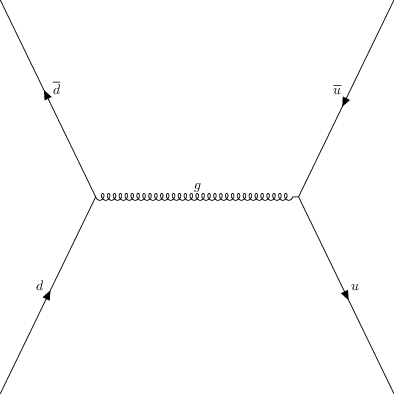

In [23]:
v1 = Vertex()
v2 = Vertex()

fd = FeynmanDiagram().add(
    v1,v2,
    Propagator(pdgid=21).connect(v1,v2),
    Leg(pdgid=1).with_target(v1).with_incoming().with_momentum(Momentum(name="$p_a$")),
    Leg(pdgid=-1).with_target(v1).with_incoming().with_momentum(Momentum(name="$p_b$")),
    Leg(pdgid=2).with_target(v2).with_outgoing().with_momentum(Momentum(name="$k_a$")),
    Leg(pdgid=-2).with_target(v2).with_outgoing().with_momentum(Momentum(name="$k_b$")),
)
fd

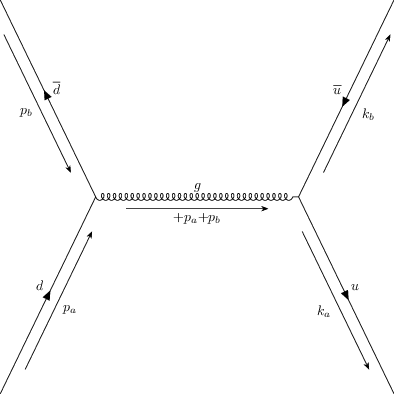

In [24]:
fd.with_rule(" * { momentum-arrow : true ; momentum-arrow-sense : -1}")
#fd.with_style_property("momentum-arrow","true")
#fd.with_style_property("momentum-arrow-sense",1)
set_missing_momenta(fd)

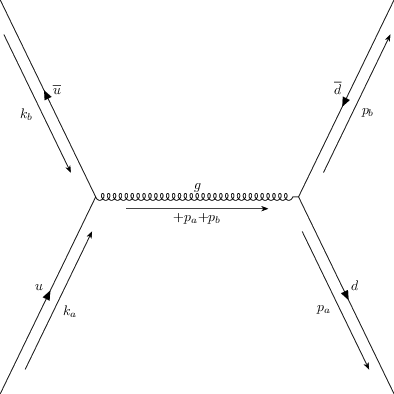

In [25]:
fd.conjugated()

In [26]:
fm = load_ufo_model("ufo_sm")

Feynman amplitude is by default represented as a string to allow easy manipulation, but can be converted to sympy and/or used in form. The definitions from UFO are used.

In [27]:
a=fp.feynman_diagram_to_string(fd,fm)
a

'complex(0,1)*G*T(GluOutPropagator79,ColLeg81,ColLeg80)*Gamma(MuOutPropagator79,SpinLeg81,SpinLeg80) * complex(0,1)*G*T(GluInPropagator79,ColLeg82,ColLeg83)*Gamma(MuInPropagator79,SpinLeg82,SpinLeg83) * VC(ColLeg80,Mom_p_a)*u(SpinLeg80,Mom_p_a) * VC(ColLeg81,Mom_p_b)*v(SpinLeg81,Mom_p_b) * VC(ColLeg82,Mom_k_a)*u_bar(SpinLeg82,Mom_k_a) * VC(ColLeg83,Mom_k_b)*v_bar(SpinLeg83,Mom_k_b) * da(GluInPropagator79,GluOutPropagator79)*Metric(MuInPropagator79,MuOutPropagator79)*Denom(+Mom_p_a+Mom_p_b,0)'

In [28]:
s2 = square([fd],fm,tag=False)

We are going to construct a single form script to perform all changes. Again as a string for ease.

In [29]:
fs = ""
fs += get_gammas()
fs += get_color()
fs += get_kinematics()
fs += get_onshell(fd,fm)
fs += get_mandelstamm_2_to_2(fd,fm)

In [30]:
rs =apply(s2,fs)
rs

'4*Den(Mom_p_a.Mom_p_a+2*Mom_p_a.Mom_p_b+Mom_p_b.Mom_p_b)^2*G^4*Nc*Cf*msu^2+4*Den(Mom_p_a.Mom_p_a+2*Mom_p_a.Mom_p_b+Mom_p_b.Mom_p_b)^2*G^4*Nc*Cf*mst^2'

Denominators are treated separately for future loop support.

In [31]:
result= apply_den(rs,get_onshell(fd,fm) + get_mandelstamm_2_to_2(fd,fm,replace_u=True))

In [32]:
ret =simplify(parse_expr(result.replace("Mom_","").replace(".","_").replace("^","**").replace("mss","s").replace("msu","u").replace("mst","t")))
ret = simplify(ret.subs("Nc","3").subs("Cf","4/3"))/2/2/3/3 # average spins and colors
ret

4*G**4*(t**2 + u**2)/(9*s**2)

In [33]:
# Ellis stirling and weber QCD and collider physics Tab 7.1
# https://feyncalc.github.io/FeynCalcExamplesMD/QCD/Tree/QiQibar-QjQjbar
expected = simplify(parse_expr("4*G**4*(t**2+u**2)/(9 *s**2)"))#.subs("s","t+u")
expected

4*G**4*(t**2 + u**2)/(9*s**2)

In [34]:
# compare
ret.equals(expected)

True